# Phase II

### Clustering

In [39]:
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2

In [40]:
df_cluster = pd.read_csv('combined_df.csv')
new_df = pd.read_csv('combined_df.csv')

#### Statistics data 

In [41]:
print("Min_Rating Count:",df_cluster["Rating Count"].min())
print("Max_Rating Count:",df_cluster["Rating Count"].max())
print("Count_Rating Count:",df_cluster["Rating Count"].count())

print("Min_Rating:",df_cluster["Rating"].min())
print("Max_Rating:",df_cluster["Rating"].max())
print("Count_Rating:",df_cluster["Rating"].count())

print("Min_Reviews:",df_cluster["Reviews"].min())
print("Max_Reviews:",df_cluster["Reviews"].max())
print("Count_Reviews:",df_cluster["Reviews"].count())

print("Min_Size:",df_cluster["Size"].min())
print("Max_Size:",df_cluster["Size"].max())
print("Count_Size:",df_cluster["Size"].count())

print("Min_Installs",df_cluster["Installs"].min())
print("Max_Installs",df_cluster["Installs"].max()) 
print("Count_Installs",df_cluster["Installs"].count())

print("Min_Price",df_cluster["Price"].min())
print("Max_Price",df_cluster["Price"].max())
print("Count_Price",df_cluster["Price"].count())

print("Min_Revenue:",df_cluster["Revenue"].min())
print("Max_Revenue",df_cluster["Revenue"].max())
print("Count_Revenue",df_cluster["Revenue"].count())

print("Min_popularity",df_cluster["popularity"].min())
print("Max_popularity",df_cluster["popularity"].max())
print("Count_popularity",df_cluster["popularity"].count())


Min_Rating Count: 5.0
Max_Rating Count: 138620959.0
Count_Rating Count: 6250
Min_Rating: 0.0
Max_Rating: 5.0
Count_Rating: 6250
Min_Reviews: 0.0
Max_Reviews: 56783331.5
Count_Reviews: 6250
Min_Size: 0.0
Max_Size: 56783331.5
Count_Size: 6250
Min_Installs 0.0
Max_Installs 5000000000.0
Count_Installs 6250
Min_Price 0.0
Max_Price 99.99
Count_Price 6250
Min_Revenue: 0.0
Max_Revenue 72400000.0
Count_Revenue 6250
Min_popularity 0.0
Max_popularity 1.161772878e+18
Count_popularity 6250


#### Numeric to Categorical for Clustering

In [42]:
# Select the numerical columns for clustering
numerical_columns = ['Rating Count','Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Revenue', 'popularity']

# Calculate the interquartile range for each column
iqr = df_cluster[numerical_columns].quantile(0.75) - df_cluster[numerical_columns].quantile(0.25)

# Calculate the number of data points
n = len(df_cluster)

# Calculate the width of each interval using the Freedman-Diaconis rule
interval_widths = 2 * iqr / (n ** (1/3))

# Calculate the best num_intervals for each column
num_intervals = (df_cluster[numerical_columns].max() - df_cluster[numerical_columns].min()) / interval_widths

# Convert num_intervals to integers
num_intervals = num_intervals.replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

# print(num_intervals)
# Divide the numerical columns into equal intervals
for column in numerical_columns:
    df_cluster[column] = df_cluster[column].astype(int)
    df_cluster[column] = pd.cut(df_cluster[column], bins=sorted(df_cluster[column].unique()))
bool_columns = ['Type']
df_cluster['Type'] = df_cluster['Type'].replace({1: True, 0: False})
df_cluster['Type'] = df_cluster['Type'].astype(bool)

df_cluster = df_cluster.drop(columns=df_cluster.columns.difference(bool_columns + numerical_columns))
df_cluster


C:\Users\new\AppData\Local\Temp\ipykernel_10752\524511089.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cluster['Type'] = df_cluster['Type'].replace({1: True, 0: False})


,Type,Rating Count,Rating,Reviews,Size,Installs,Price,Revenue,popularity
0,False,"(1112, 1114]","(2, 3]","(312, 313]","(312, 313]","(50000, 100000]",NaN,NaN,"(108319150.0, 108330000.0]"
1,False,"(92643, 92790]","(3, 4]","(39497, 39499]","(39497, 39499]","(5000000, 10000000]",NaN,NaN,NaN
2,False,"(16591, 16599]","(3, 4]","(9679, 9690]","(9679, 9690]","(500000, 1000000]",NaN,NaN,NaN
3,False,"(109, 110]","(3, 4]","(22434, 22435]","(22434, 22435]","(5000, 10000]",NaN,NaN,"(930325000.0, 931094000.0]"
4,False,"(50072, 50147]","(3, 4]","(32436, 32554]","(32436, 32554]","(5000000, 10000000]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6245,False,"(5779, 5780]","(3, 4]","(3422, 3436]","(3422, 3436]","(50000, 100000]",NaN,NaN,"(1363885250.0, 1375000000.0]"
6246,False,"(7634, 7645]","(3, 4]","(4065, 4079]","(4065, 4079]","(500000, 1000000]",NaN,NaN,NaN
6247,False,"(1058, 1061]","(3, 4]","(557, 558]","(557, 558]","(100000, 500000]",NaN,NaN,"(1164960000.0, 1174950000.0]"
6248,False,"(91942, 91972]","(2, 3]","(60127, 60156]","(60127, 60156]","(1000000, 5000000]",NaN,NaN,NaN


### Kmeans Algorithm

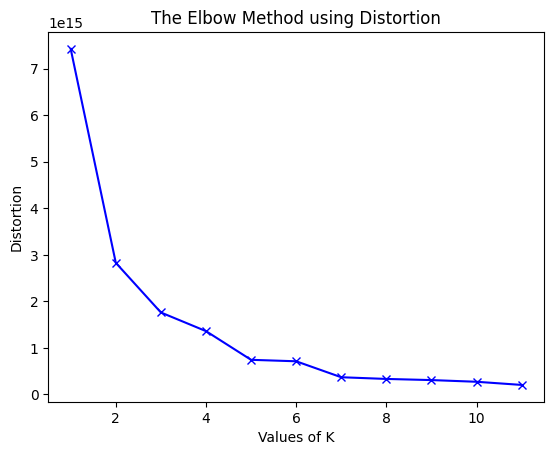

In [43]:
distortions = []
inertias = {}
mapping1 = {}
mapping2 = {}
K = range(1, 12)

kmeans_check_df = new_df.copy()
kmeans_check_df = kmeans_check_df.drop(columns=kmeans_check_df.columns.difference(bool_columns + numerical_columns))


x_train = kmeans_check_df

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=15).fit(x_train)
    distortions.append(sum(np.min(cdist(x_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / x_train.shape[0])
    inertias[k] = kmeanModel.inertia_
    mapping1[k] = sum(np.min(cdist(x_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / x_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

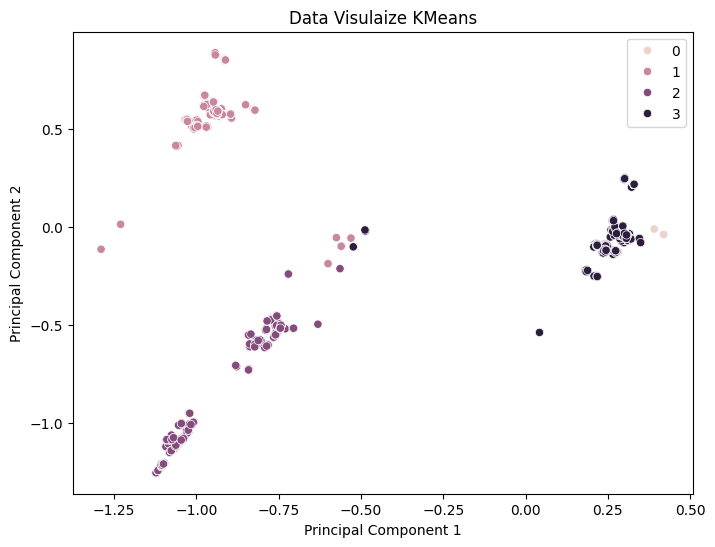

array([[-0.94824816,  0.64315056, -0.29767873],
       [ 0.41929332, -0.03722927, -0.59795527],
       [ 0.32959775,  0.21922066,  0.76930479],
       ...,
       [ 0.30047814, -0.03122925,  0.00355318],
       [-0.89604377,  0.57775332, -0.17548115],
       [ 0.30658716, -0.03983274, -0.02277784]])

In [44]:
K = 4
df_dummies = pd.get_dummies(df_cluster)
kmeans = KMeans(n_clusters=K, max_iter=100, n_init=20, random_state=42)
kmeans_labels = kmeans.fit_predict(df_dummies)
pca = PCA(n_components=3)
temp = pca.fit_transform(df_dummies)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=temp[:, 0], y=temp[:, 1], hue=kmeans_labels)
plt.title('Data Visulaize KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
temp

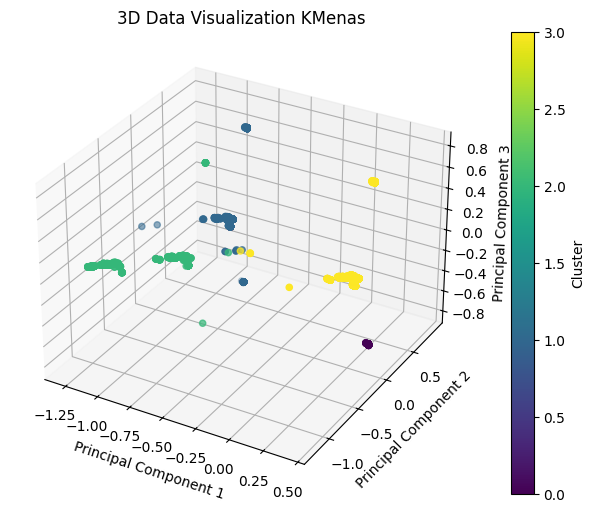

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(temp[:, 0], temp[:, 1], temp[:, 2], c=kmeans_labels, cmap='viridis')

ax.set_title('3D Data Visualization KMenas')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

#### Find frequent pattern in each cluster

In [46]:
# result_set = set()

# for i in range(K):
#   # print(f"cluster status {i}")
#   cluster_df = df_dummies[kmeans_labels == i]
#   for index, col in enumerate(cluster_df.columns):
#       if len(cluster_df.columns) != index:
#         for index1 in range(index + 1):
#           if cluster_df[col].dtype == "bool" and cluster_df[cluster_df.columns[index1]].dtype == "bool":
#             frequent = get_frequent_itemsets(col, cluster_df.columns[index1], continuous=False)
#             rules = association_rules(frequent, metric='support', min_threshold=0.5)
#             if not rules.empty:
#                 result_set.add((col, cluster_df.columns[index1], i, tuple(map(tuple, rules.to_numpy()))))


### DBSCAN Algorithm

[   0    1    2 ... 5560 5561 5562]


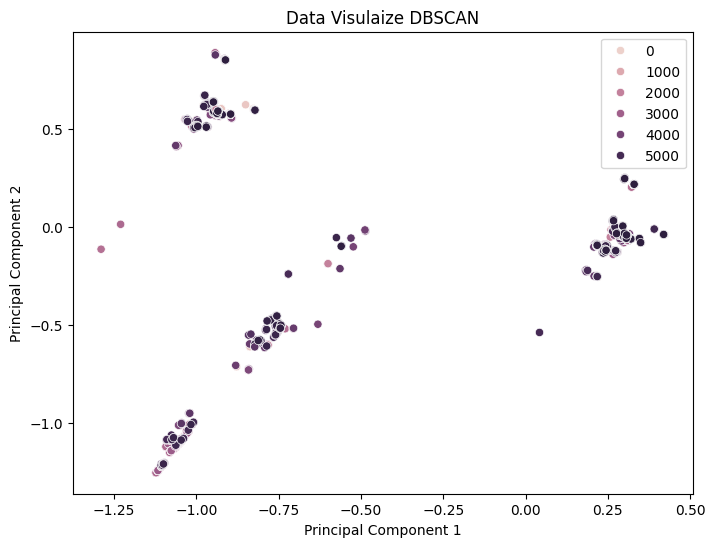

In [47]:
df_dummies = pd.get_dummies(df_cluster)
cluster = DBSCAN(eps=0.8, min_samples=1).fit_predict(df_dummies)
print(np.unique(cluster))
pca = PCA(n_components=2)
temp = pca.fit_transform(df_dummies)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=temp[:, 0], y=temp[:, 1], hue=cluster)
plt.title('Data Visulaize DBSCAN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

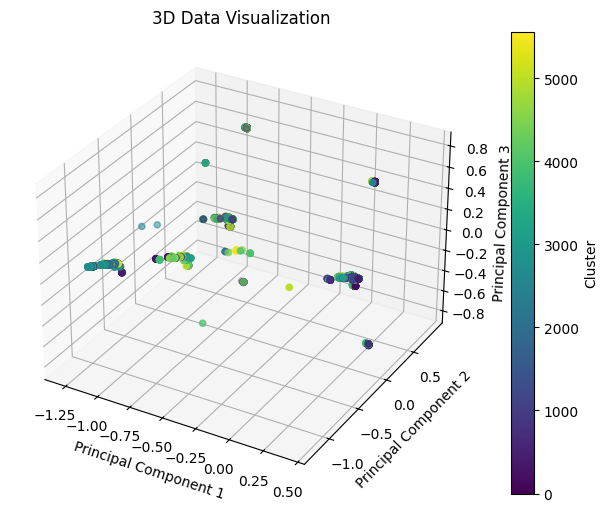

In [48]:
df_dummies = pd.get_dummies(df_cluster)
cluster = DBSCAN(eps=0.8, min_samples=1).fit_predict(df_dummies)
pca = PCA(n_components=3)
temp = pca.fit_transform(df_dummies)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(temp[:, 0], temp[:, 1], temp[:, 2], c=cluster, cmap='viridis')

# Customize the plot
ax.set_title('3D Data Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()